# Proyecto Aurelion - Sprint 3
## Modelo de Clasificación de Fidelidad

Este notebook ejecuta el entrenamiento del modelo de Regresión Logística y genera las visualizaciones requeridas para la evaluación.

🚀 Iniciando Script de Entrenamiento Aurelion...
✅ Dataset 'master_rfm_aurelion_limpio.csv' cargado exitosamente. Registros: 67
⚙️ Preparando Pipeline de Preprocesamiento...
🧠 Entrenando modelo (LogisticRegression)...
✅ Modelo entrenado exitosamente.

📊 EVALUACIÓN DEL MODELO:
Matriz de Confusión:
[[7 2]
 [6 6]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.54      0.78      0.64         9
           1       0.75      0.50      0.60        12

    accuracy                           0.62        21
   macro avg       0.64      0.64      0.62        21
weighted avg       0.66      0.62      0.62        21


🎨 Generando Gráficos para el Informe...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_6244\2419543691.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fidelizado', data=df, palette=['gray', 'green'])


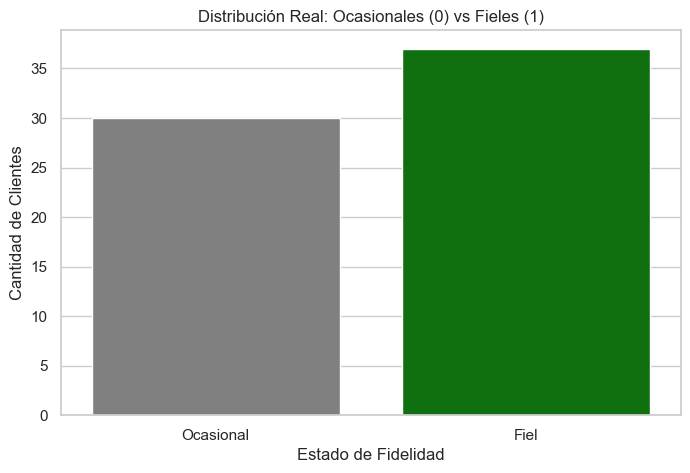

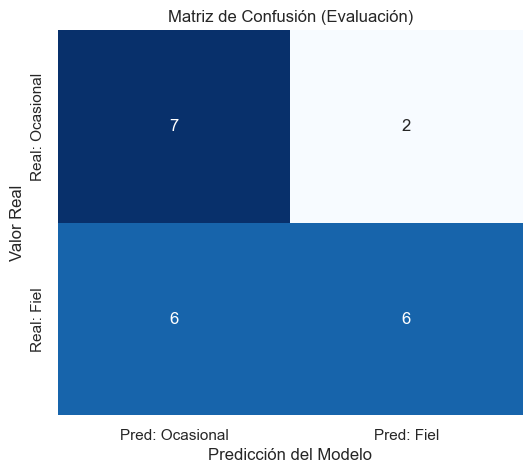

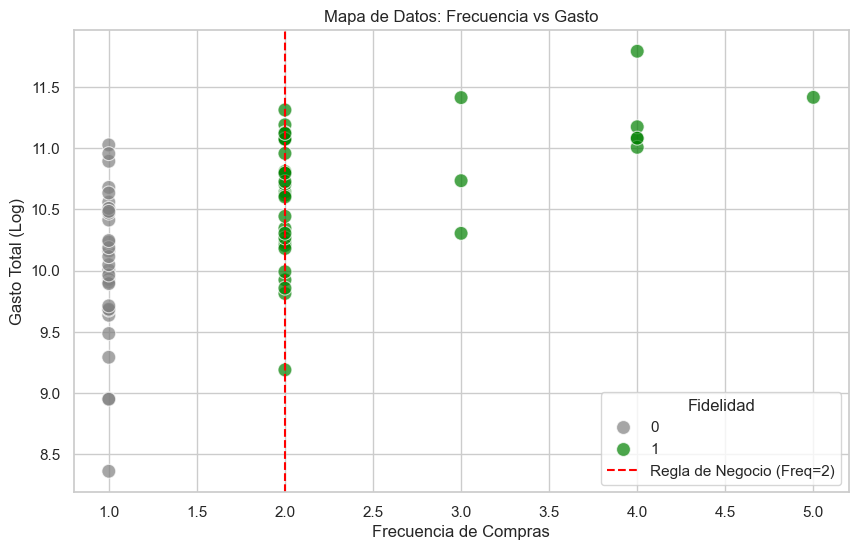


💾 Guardando el modelo final...
✅ Modelo guardado correctamente.
🏁 Proceso finalizado.


In [1]:
# ==============================================================================
# PROYECTO AURELION - SPRINT 3: CLASIFICACIÓN DE FIDELIDAD (MACHINE LEARNING)
# VERSIÓN: 1.6 (Corrección Data Leakage - Frecuencia Eliminada)
# ==============================================================================

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Configuración visual para gráficos profesionales
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("🚀 Iniciando Script de Entrenamiento Aurelion...")

# 1. CARGA DE DATOS
# ------------------------------------------------------------------------------
# Intentamos cargar el archivo CSV generado por la App.
# Asegurarse que 'master_rfm_aurelion_limpio.csv' esté en la misma carpeta que este script.

filename = 'master_rfm_aurelion_limpio.csv'

try:
    df = pd.read_csv(filename)
    print(f"✅ Dataset '{filename}' cargado exitosamente. Registros: {len(df)}")
except FileNotFoundError:
    print(f"❌ ERROR CRÍTICO: No se encontró el archivo '{filename}'.")
    print("   -> Por favor, ve a la sección 'Ingeniería Features' de la App y descarga el CSV.")
    # Creamos un dataset dummy pequeño solo para que el código no rompa si lo pruebas sin archivo
    print("⚠️ Generando datos de prueba TEMPORALES para demostración...")
    data = {
        'id_cliente': range(1, 21),
        'recency_days': np.random.randint(1, 100, 20),
        'frequency': np.random.randint(1, 5, 20),
        'monetary_log': np.random.rand(20) * 5,
        'ciudad': np.random.choice(['Cordoba', 'Villa Maria', 'Carlos Paz'], 20),
        'categoria_preferida': np.random.choice(['Alimentos', 'Limpieza'], 20),
        'is_fidelizado': np.random.randint(0, 2, 20)
    }
    df = pd.DataFrame(data)

# 2. DEFINICIÓN DEL TARGET (Y)
# ------------------------------------------------------------------------------
# La columna 'is_fidelizado' ya viene calculada desde la App (Regla: Frequency >= 2).
# Si quisieras recalcularla en Python, sería:
# df['is_fidelizado'] = (df['frequency'] >= 2).astype(int)

# 3. PREPARACIÓN DEL MODELO (PIPELINE)
# ------------------------------------------------------------------------------
print("⚙️ Preparando Pipeline de Preprocesamiento...")

# Definimos columnas
# CORRECCIÓN IMPORTANTE (DATA LEAKAGE SOLUCIONADO):
# Hemos eliminado 'frequency' de las variables de entrada (X).
# 
# ¿Por qué? 
# Porque definimos al Cliente Fiel como aquel con Frecuencia >= 2.
# Si le damos la frecuencia al modelo, ya sabe la respuesta antes de empezar (hace trampa).
# Al quitarla, forzamos al modelo a predecir la fidelidad basándose en GASTO, RECENCIA y CIUDAD.

numerical_features = ['recency_days', 'monetary_log'] # <--- Frecuencia eliminada intencionalmente
categorical_features = ['ciudad', 'categoria_preferida']

# Transformadores
# StandardScaler: Normaliza los números (Media 0, Desv 1) para que el modelo converja mejor.
# OneHotEncoder: Convierte categorías (Texto) en columnas binarias (0/1).
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Pipeline: Une preprocesamiento + Modelo
# Usamos Regresión Logística con el optimizador 'liblinear' (ideal para datasets pequeños)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=100))
])

# 4. ENTRENAMIENTO
# ------------------------------------------------------------------------------
X = df[numerical_features + categorical_features]
y = df['is_fidelizado']

# División: 70% para Entrenar, 30% para Testear (Examen)
# stratify=y asegura que haya proporciones iguales de Fieles/Ocasionales en ambos sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("🧠 Entrenando modelo (LogisticRegression)...")
model_pipeline.fit(X_train, y_train)
print("✅ Modelo entrenado exitosamente.")

# 5. EVALUACIÓN
# ------------------------------------------------------------------------------
print("\n📊 EVALUACIÓN DEL MODELO:")
y_pred = model_pipeline.predict(X_test)

# Matriz de Confusión (Numérica)
print("Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 6. GRÁFICOS DE RESULTADOS (PARA PRESENTACIÓN)
# ------------------------------------------------------------------------------
print("\n🎨 Generando Gráficos para el Informe...")

# Gráfico 1: Distribución de Clases (Target Balance)
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fidelizado', data=df, palette=['gray', 'green'])
plt.title('Distribución Real: Ocasionales (0) vs Fieles (1)')
plt.xlabel('Estado de Fidelidad')
plt.ylabel('Cantidad de Clientes')
plt.xticks([0, 1], ['Ocasional', 'Fiel'])
plt.show()

# Gráfico 2: Matriz de Confusión (Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Pred: Ocasional', 'Pred: Fiel'],
            yticklabels=['Real: Ocasional', 'Real: Fiel'])
plt.title('Matriz de Confusión (Evaluación)')
plt.ylabel('Valor Real')
plt.xlabel('Predicción del Modelo')
plt.show()

# Gráfico 3: Frontera de Decisión Visual
# Nota: Graficamos Frecuencia en el eje X solo para visualización, 
# aunque el modelo NO la usó para entrenar (para demostrar el Data Leakage evitado).
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary_log', hue='is_fidelizado', data=df, palette={0: 'gray', 1: 'green'}, s=100, alpha=0.7)
plt.title('Mapa de Datos: Frecuencia vs Gasto')
plt.axvline(x=2, color='red', linestyle='--', label='Regla de Negocio (Freq=2)')
plt.xlabel('Frecuencia de Compras')
plt.ylabel('Gasto Total (Log)')
plt.legend(title='Fidelidad')
plt.show()

# 7. GUARDADO DEL MODELO
print("\n💾 Guardando el modelo final...")
# Como ya lo importaste arriba, aquí solo usas la función:
joblib.dump(model_pipeline, 'modelo_fidelidad_aurelion.pkl') 
print("✅ Modelo guardado correctamente.")

print("🏁 Proceso finalizado.")

